In [222]:
from xgboost import XGBRegressor, DMatrix, cv, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import os

In [63]:
path = os.path.realpath('..')
data_path = os.path.join(path, 'Small Datasets', 'auto-mpg.csv')

In [64]:
df = pd.read_csv(data_path)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [65]:
df = df[df['horsepower']!='?']
df['horsepower'] = [int(i) for i in df['horsepower']]

In [66]:
X, y = df.drop('mpg', axis=1), df['mpg']

In [67]:
encoder = LabelEncoder()
X['car name'] = encoder.fit_transform(X['car name'])

In [68]:
X.shape

(392, 8)

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [187]:
[i.shape for i in [X_train, X_test, y_train, y_test]]

[(313, 8), (79, 8), (313,), (79,)]

In [188]:
#Learning rate - 0,1 step size during optimization
#max_depth - depth of each tree every boosting round
#subsample - % of samples per tree, smaller = underfitting
#colsample_bytree - % of features per tree, higher = overfitting
#n_estimators - number of trees
#objective - determine loss function

##Regularization params
#gamma - Threshold for splitting a node based on reduction in loss. higher = lesser splits
#alpha - L1 regularization on leaf node. Bigger = more regularization
#lambda - L2 regularization on leaf node, smoother than L1 regularization
#booster - gbtree, gblinear, dart

In [204]:
xgb = XGBRegressor(learning_rate=0.1, 
                   max_depth=3, 
                   subsample=1, 
                   colsample_bytree=1, 
                   objective='reg:linear', 
                   n_estimators=75, 
                   n_jobs=-1, reg_alpha=1)

xgb.fit(X_train, y_train)

/Users/akshay/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=75, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=1,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [205]:
xgb.score(X_train, y_train)

0.9585312824756493

In [206]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [207]:
y_pred = xgb.predict(X_test)

In [208]:
mean_absolute_error(y_test,y_pred)

1.7894348965415472

In [209]:
np.sqrt(mean_squared_error(y_test,y_pred))

2.457869325303451

In [210]:
r2_score(y_test,y_pred)

0.8816408191913213

In [196]:
sorted([i for i in zip(X_train.columns,xgb.feature_importances_)], key=lambda x:x[1], reverse=True)

[('displacement', 0.32425264),
 ('cylinders', 0.29772082),
 ('weight', 0.15863286),
 ('model year', 0.0941279),
 ('horsepower', 0.08238424),
 ('origin', 0.01988765),
 ('car name', 0.011505777),
 ('acceleration', 0.011488129)]

### Cross validation

In [211]:
#nfolds - number of cv folds
#metrics - evaluation metrics
#as_pandas - return results as df
#early_stopping_rounds - finishes model training early if holdoutmetric doesnt improve with rounds
#seed - random seed

##In params, define all parameters but instead of n_estimators, use num_boost_rounds

In [212]:
data_dmatrix = DMatrix(data=X, label=y)

/Users/akshay/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/akshay/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [216]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1, 'max_depth': 5, 'alpha': 10}

In [219]:
results = cv(dtrain=data_dmatrix, params = params, 
               nfold=3, num_boost_round=50, 
               early_stopping_rounds=10, 
               metrics='rmse', as_pandas=True, 
               seed=111)

In [220]:
print((results["test-rmse-mean"]).tail(1))

49    3.091294
Name: test-rmse-mean, dtype: float64


In [225]:
import matplotlib.pyplot as plt

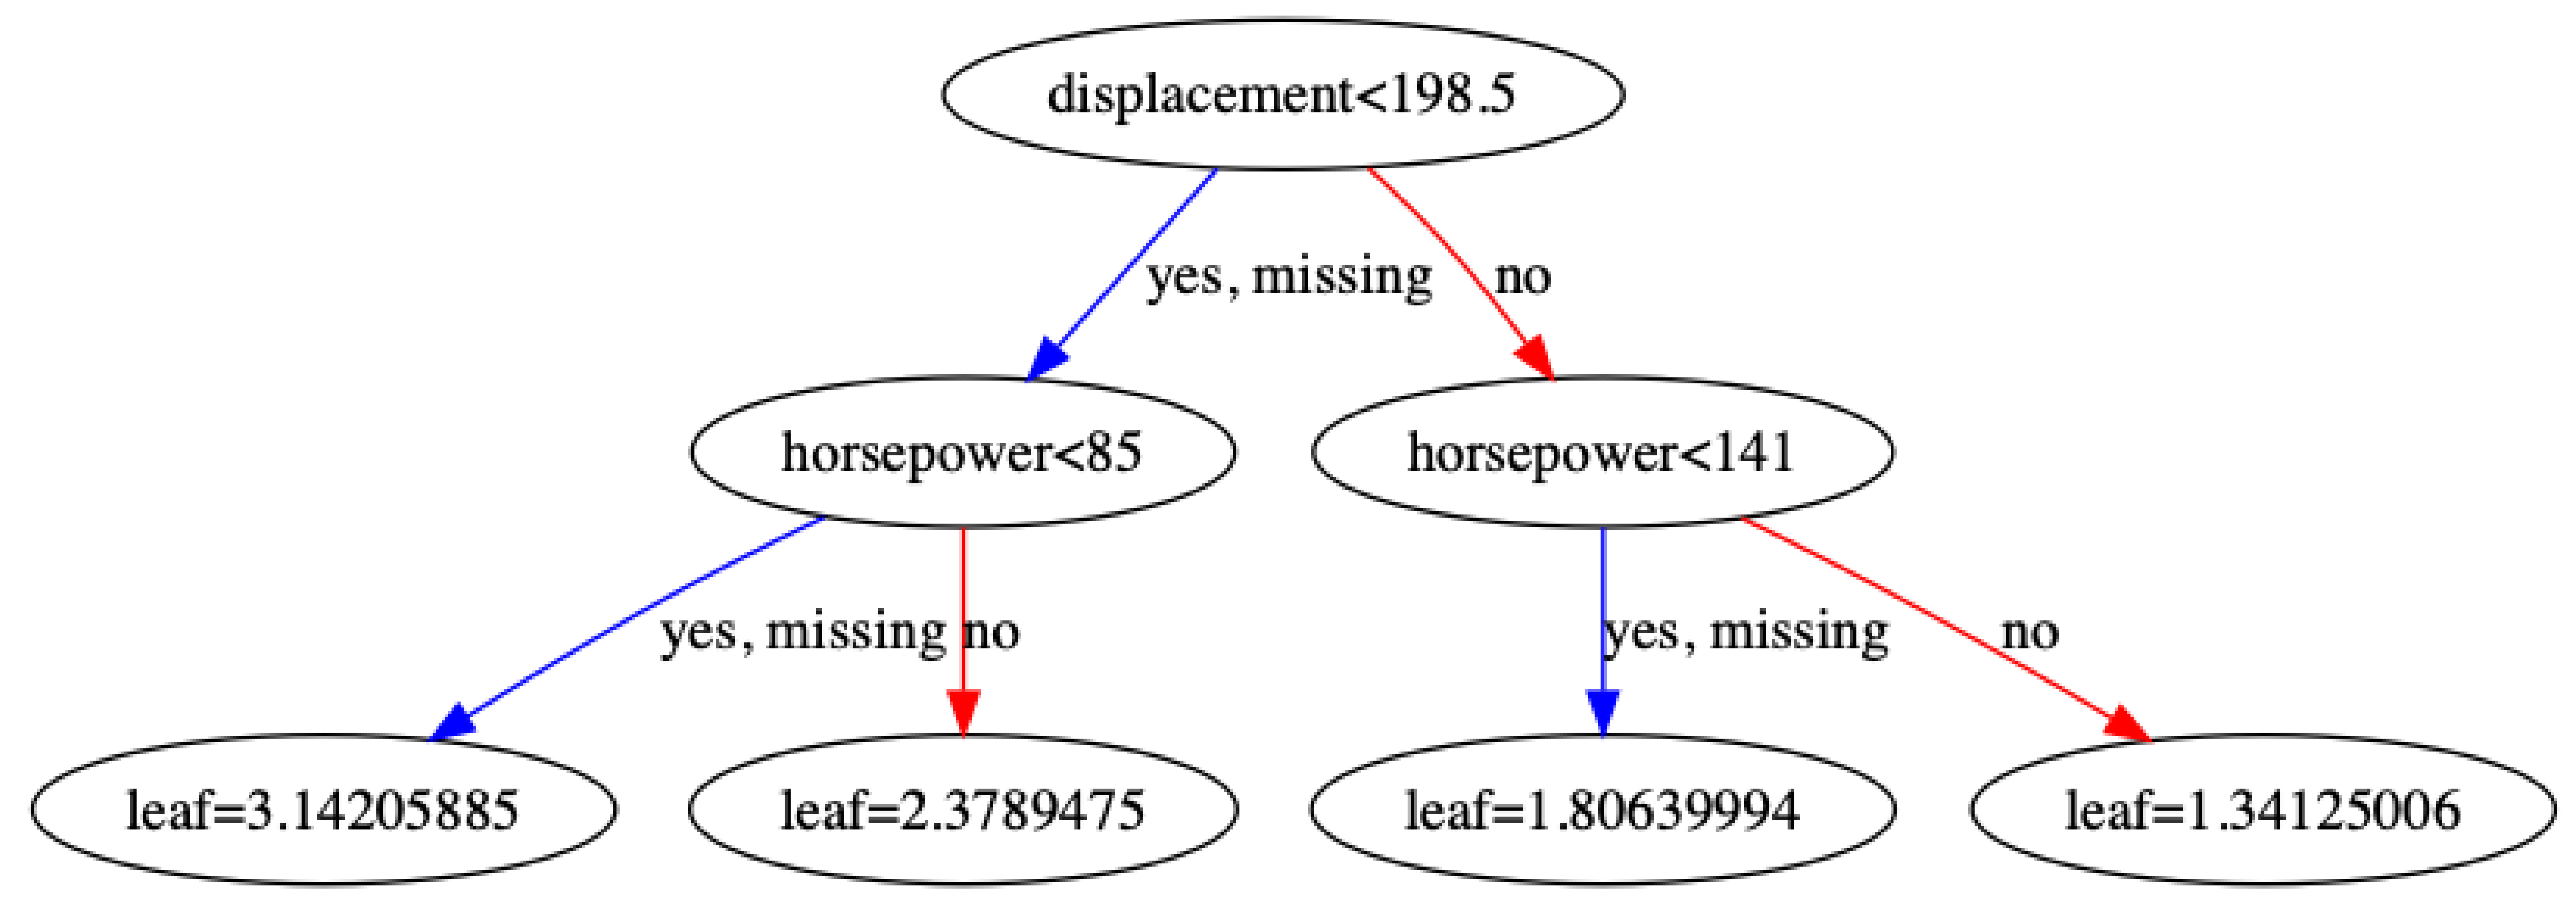

In [232]:
plot_tree(xgb,num_trees=0)
plt.rcParams['figure.figsize'] = [80, 40]
plt.show()